In [10]:
import torch
import torch.nn.functional as F
import numpy as np
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
from src.quantize import cluster_feat

In [2]:
DATASET = "imagenet_captions_50k"

### Create Dataset

In [3]:
data_dir = f"/mnt/ssd/ronak/datasets/{DATASET}"

img = torch.from_numpy(torch.load(os.path.join(data_dir, "vit_b32_laion2b_image_features.pt")))
txt = torch.from_numpy(torch.load(os.path.join(data_dir, "vit_b32_laion2b_text_features.pt")))
idx = torch.load(os.path.join(data_dir, "vit_b32_laion2b_idx.pt"))

In [4]:
# data should be prenormalized
np.linalg.norm(img[:10], axis=1)

array([1.        , 1.        , 1.0000001 , 0.99999994, 1.        ,
       1.        , 1.        , 0.99999994, 1.        , 1.        ],
      dtype=float32)

In [5]:
n = len(img)
np.random.seed(123)
test_size = int(0.1 * n)

train_idx = np.random.choice(n, size=(n - test_size), replace=False)
test_idx = np.delete(np.arange(n), train_idx)
assert len(np.intersect1d(train_idx, test_idx)) == 0
assert len(np.union1d(train_idx, test_idx)) == n

In [6]:
train_idx = torch.from_numpy(train_idx)
test_idx = torch.from_numpy(test_idx)

x_train, x_test = img[train_idx], img[test_idx]
y_train, y_test = txt[train_idx], txt[test_idx]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([43422, 512])
torch.Size([43422, 512])
torch.Size([4824, 512])
torch.Size([4824, 512])


In [7]:
torch.save(x_train, os.path.join(data_dir, "x_train.pt"))
torch.save(y_train, os.path.join(data_dir, "y_train.pt"))
torch.save(x_test, os.path.join(data_dir, "x_test.pt"))
torch.save(y_test, os.path.join(data_dir, "y_test.pt"))

### Perform Quantization

In [3]:
NUM_CLUSTERS = 100
SEED = 4282022
MODEL_NAME = "vit_b32_laion2b"
DATA_PATH = f'/mnt/ssd/ronak/datasets/{DATASET}'

In [4]:
all_image_features = torch.load(os.path.join(DATA_PATH, "x_train.pt"))
all_text_features = torch.load(os.path.join(DATA_PATH, "y_train.pt"))

In [5]:
image_labels, image_cluster = cluster_feat(all_image_features, NUM_CLUSTERS, seed=SEED)
_, counts = np.unique(image_labels, return_counts=True)
image_marginal = counts / counts.sum()
print(f"image marginal: {image_marginal}")

image marginal: [0.0117452  0.00907374 0.0214868  0.00905071 0.01515361 0.01455483
 0.01006402 0.01683478 0.01602874 0.02590853 0.01570632 0.01787113
 0.01559117 0.01052462 0.00916586 0.00845194 0.01142278 0.012367
 0.01388697 0.01036341 0.01939109 0.01218276 0.01061674 0.0067247
 0.01667358 0.01600571 0.01941412 0.00658652 0.01644328 0.01503846
 0.00937313 0.01008705 0.01393303 0.01324214 0.00902768 0.01644328
 0.01685781 0.01331122 0.00930404 0.01015614 0.01315002 0.00939616
 0.00624108 0.01186035 0.0078071  0.01310396 0.0093501  0.02422735
 0.00808346 0.01787113 0.0147621  0.01073189 0.01204459 0.00870526
 0.00971858 0.01777901 0.01215973 0.00928101 0.00987978 0.0523928
 0.02293768 0.02079591 0.01031735 0.01047856 0.01770992 0.00983372
 0.01490028 0.02153286 0.00891253 0.00769195 0.01469301 0.00854406
 0.00928101 0.00776104]


In [6]:
text_labels, text_cluster = cluster_feat(all_text_features, NUM_CLUSTERS, seed=SEED)
_, counts = np.unique(text_labels, return_counts=True)
text_marginal = counts / counts.sum()
print(f"image marginal: {text_marginal}")

image marginal: [0.01547603 0.0088895  0.02033531 0.00736954 0.01006402 0.01326517
 0.01363364 0.00654046 0.01727235 0.01135369 0.09142831 0.00764589
 0.01906867 0.00690894 0.01741053 0.00716227 0.00840588 0.00944222
 0.01239003 0.00902768 0.00969555 0.01130763 0.0143706  0.03132053
 0.02740546 0.01123854 0.00948828 0.00882041 0.01397909 0.01858505
 0.01457786 0.01711114 0.0080374  0.03645617 0.01814748 0.00764589
 0.01941412 0.01222882 0.01250518 0.01275851 0.0115149  0.0143706
 0.01052462 0.00723136 0.0156142  0.00644834 0.01559117 0.09983419
 0.012367   0.12168947 0.00877435 0.00697803 0.01538391 0.02549399]


In [7]:
print(image_marginal.max() / image_marginal.min())
print(text_marginal.max() / text_marginal.min())

8.394833948339484
18.871428571428574


In [8]:
save_dir = f'/mnt/ssd/ronak/datasets/{DATASET}/quantization/{MODEL_NAME}_kmeans_{NUM_CLUSTERS}'
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, f'image_labels.npy'), image_labels)
np.save(os.path.join(save_dir, f'text_labels.npy'), text_labels)
np.save(os.path.join(save_dir, f'image_marginal.npy'), image_marginal)
np.save(os.path.join(save_dir, f'text_marginal.npy'), text_marginal)

In [11]:
print(os.path.join(save_dir, f'image_labels.npy'))

/mnt/ssd/ronak/datasets/imagenet_captions_50k/quantization/vit_b32_laion2b_kmeans_100/image_labels.npy


In [9]:
# bad event probability
def simulate_probability(arr, b, s=1000):
    np.random.seed(123)
    num_clusters = len(np.unique(arr))
    count = 0
    for _ in range(s):
        batch = np.random.choice(arr, size=(b,), replace=False)
        count += int(len(np.unique(batch)) == num_clusters)
    return count / s

def make_plot(num_clusters, dataset):
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"{dataset}")

    model_name = "vit_b32_laion2b"
    save_dir = f'/mnt/ssd/ronak/datasets/{dataset}/quantization/{model_name}_kmeans_{num_clusters}'

    image_labels_sorted = np.load(os.path.join(save_dir, f'image_labels.npy'))
    text_labels_sorted = np.load(os.path.join(save_dir, f'text_labels.npy'))

    print(len(np.unique(image_labels_sorted)))

    make_ax(axes[0], image_labels_sorted, "Image")
    make_ax(axes[1], text_labels_sorted, "Text")

    plt.show()

def make_ax(ax, arr, modality):
    probs = []
    batch_sizes =  [16, 32, 64, 128, 256, 512, 1024]
    for b in tqdm(batch_sizes):
        probs.append(simulate_probability(arr, b))

    _, counts = np.unique(arr, return_counts=True)
    # avg_count = sum(counts ** 2) / counts.sum()
    avg_count = np.mean(counts)
    print(f"{modality} marginal: {counts / counts.sum()}")

    ax.plot(batch_sizes, probs, linewidth=3)
    ax.set_xlabel("Batch Size")
    ax.set_ylabel("Probability of Good Event")
    ax.set_xscale("log")
    ax.set_xticks(batch_sizes)
    ax.set_xticklabels(batch_sizes)
    ax.set_title(f"{len(counts)} {modality} Clusters (Avg. Size {avg_count:0.2f})")

74


100%|██████████| 7/7 [00:03<00:00,  1.78it/s]


Image marginal: [0.0117452  0.00907374 0.0214868  0.00905071 0.01515361 0.01455483
 0.01006402 0.01683478 0.01602874 0.02590853 0.01570632 0.01787113
 0.01559117 0.01052462 0.00916586 0.00845194 0.01142278 0.012367
 0.01388697 0.01036341 0.01939109 0.01218276 0.01061674 0.0067247
 0.01667358 0.01600571 0.01941412 0.00658652 0.01644328 0.01503846
 0.00937313 0.01008705 0.01393303 0.01324214 0.00902768 0.01644328
 0.01685781 0.01331122 0.00930404 0.01015614 0.01315002 0.00939616
 0.00624108 0.01186035 0.0078071  0.01310396 0.0093501  0.02422735
 0.00808346 0.01787113 0.0147621  0.01073189 0.01204459 0.00870526
 0.00971858 0.01777901 0.01215973 0.00928101 0.00987978 0.0523928
 0.02293768 0.02079591 0.01031735 0.01047856 0.01770992 0.00983372
 0.01490028 0.02153286 0.00891253 0.00769195 0.01469301 0.00854406
 0.00928101 0.00776104]


100%|██████████| 7/7 [00:03<00:00,  1.82it/s]


Text marginal: [0.01547603 0.0088895  0.02033531 0.00736954 0.01006402 0.01326517
 0.01363364 0.00654046 0.01727235 0.01135369 0.09142831 0.00764589
 0.01906867 0.00690894 0.01741053 0.00716227 0.00840588 0.00944222
 0.01239003 0.00902768 0.00969555 0.01130763 0.0143706  0.03132053
 0.02740546 0.01123854 0.00948828 0.00882041 0.01397909 0.01858505
 0.01457786 0.01711114 0.0080374  0.03645617 0.01814748 0.00764589
 0.01941412 0.01222882 0.01250518 0.01275851 0.0115149  0.0143706
 0.01052462 0.00723136 0.0156142  0.00644834 0.01559117 0.09983419
 0.012367   0.12168947 0.00877435 0.00697803 0.01538391 0.02549399]


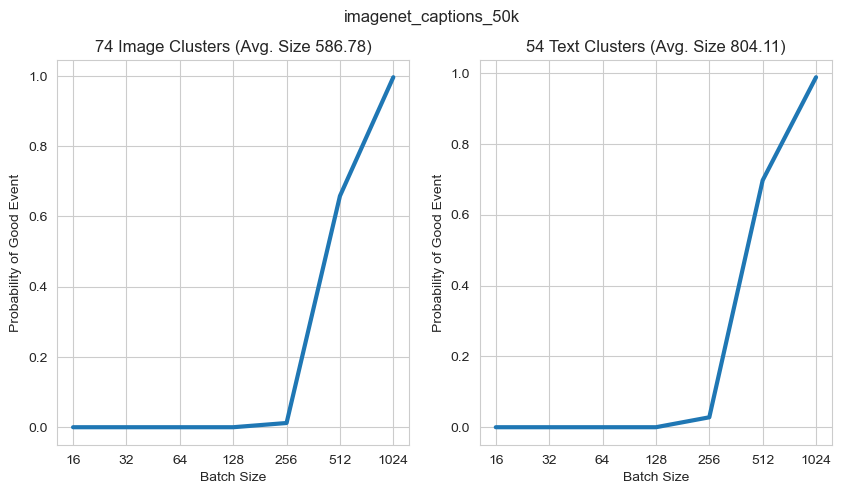

In [10]:
num_clusters = 100

make_plot(num_clusters, DATASET)

### Compute Baseline Loss

In [11]:
def compute_clip_loss(x, y, scale=100.0):
    # scale is taken from vit_b32_laion2b model
    logits = torch.matmul(x, y.T) * scale
    labels = torch.arange(len(logits))
    loss_i = torch.nn.functional.cross_entropy(logits, labels)
    loss_t = torch.nn.functional.cross_entropy(logits.T, labels)
    loss = (loss_i + loss_t) / 2
    return loss

def compute_jointly_centered_loss(x, y, scale=100.0):
    # scale is taken from vit_b32_laion2b model
    logits = torch.matmul(x, y.T) * scale
    norm_factor = torch.logsumexp(torch.flatten(logits), dim=0)
    loss = -torch.mean(torch.diagonal(logits) - norm_factor)
    return loss

def compute_doubly_centered_loss(x, y, scale=100.0):
    # scale is taken from vit_b32_laion2b model
    logits = torch.matmul(x, y.T) * scale
    cx   = F.log_softmax(logits, dim=1)
    cy   = F.log_softmax(logits, dim=0)
    cycx = F.log_softmax(cx, dim=0)
    cxcy = F.log_softmax(cy, dim=1)
    loss = -torch.mean(0.5 * torch.diagonal(cycx) + 0.5 * torch.diagonal(cxcy))
    return loss
        
def compute_loss(batch_size, X, Y, batch_loss, n_bootstrap=3000):
    N = len(X)
    np.random.seed(123)
    losses = torch.zeros(n_bootstrap)
    for i in tqdm(range(n_bootstrap)):
        idx = np.random.choice(N, size=(batch_size,), replace=False)
        losses[i] = batch_loss(X[idx], Y[idx])
    return losses.mean()

model_name = 'vit-b32-laion2b_s34b_b79k'

In [6]:
data_dir = f"/mnt/ssd/ronak/datasets/{DATASET}"

x_train = torch.load(os.path.join(data_dir, "x_train.pt"))
y_train = torch.load(os.path.join(data_dir, "y_train.pt"))
x_test = torch.load(os.path.join(data_dir, "x_test.pt"))
y_test = torch.load(os.path.join(data_dir, "y_test.pt"))

In [7]:
# CLIP Loss

batch_size = 512

train_loss = compute_loss(batch_size, x_train, y_train, compute_clip_loss)
test_loss = compute_loss(batch_size, x_test, y_test, compute_clip_loss)

print(f"model:        {model_name}")
print(f"batch size:   {batch_size}")
print(f"  train loss: {train_loss:0.5f}")
print(f"  test loss:  {test_loss:0.5f}")

100%|██████████| 3000/3000 [00:05<00:00, 524.70it/s]

model:        vit-b32-laion2b_s34b_b79k
batch size:   512
  train loss: 4.48539
  test loss:  4.56147


In [8]:
# Jointly Centered CLIP Loss

batch_size = 512

train_loss = compute_loss(batch_size, x_train, y_train, compute_jointly_centered_loss)
test_loss = compute_loss(batch_size, x_test, y_test, compute_jointly_centered_loss)

print(f"model:        {model_name}")
print(f"batch size:   {batch_size}")
print(f"  train loss: {train_loss:0.5f}")
print(f"  test loss:  {test_loss:0.5f}")

100%|██████████| 3000/3000 [00:03<00:00, 815.34it/s]

model:        vit-b32-laion2b_s34b_b79k
batch size:   512
  train loss: 15.30892
  test loss:  16.47509


In [12]:
# Doubly Centered CLIP Loss

batch_size = 512

train_loss = compute_loss(batch_size, x_train, y_train, compute_doubly_centered_loss)
test_loss = compute_loss(batch_size, x_test, y_test, compute_doubly_centered_loss)

print(f"model:        {model_name}")
print(f"batch size:   {batch_size}")
print(f"  train loss: {train_loss:0.5f}")
print(f"  test loss:  {test_loss:0.5f}")

100%|██████████| 3000/3000 [00:06<00:00, 429.04it/s]

model:        vit-b32-laion2b_s34b_b79k
batch size:   512
  train loss: 3.70584
  test loss:  3.76065
